# Quiz

# Would Anyone Like to Give Their Simple Explanation of Gradient Descent?

# Review: Machine Learning Model Training Workflow

1. Collect (and label, if necessary) data
2. Define objective function; select performance metrics
3. Select model architecture(s)
4. Select optimization algorithm for each model architecture
5. Split data into train/dev/test (*what are our options for how to do this?*)
6. For each selection of hyperparameters, train on train; evaluate on dev
7. For best selection of hyperparameters, evaluate on test

# Generalization

We split our data into train/dev/test (or training and validation) because we want to see if a model trained (on training data) can *generalize* to the test data. In other words, we want low loss on the training data *and* low loss on the test data. 

What's one easy way to get loss of 0 on the training data? Would a model like that generalize?

## Assumptions Will Be Our Ruin

We assume that the data we collected is a "good sample". What's a good sample?

Furthermore, we assume that our split into train/dev/test is a "good split". What's a good split?

We do cross-validation *because a single train/dev/test split may be pathological*:
* https://direct.mit.edu/neco/article-abstract/10/7/1895/6224/Approximate-Statistical-Tests-for-Comparing

But for a competition generally there is a *single* train/dev/test split. Bad things can happen! Examples:
* https://aclanthology.org/P19-1267.pdf
* https://aclanthology.org/2021.emnlp-main.368/
* https://arxiv.org/pdf/2005.00636.pdf

## The Nature of the Task, the Size of the Data and the Complexity of the Model All Interact

All machine learning tasks are about fitting (approximating) a function characterized by the training data.

If your function is super easy (e.g. label is a multiple of one variable) then a simple model architecture can fit it well.

If your function is complex then you need more data and/or a more complex model architecture to fit it well.

A complex model architecture and not enough data means your model will probably not generalize well.

## Let's Take a Look

In [1]:
!pip install torch torchvision
!pip install d2l==1.0.0b0
!pip install wandb


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python -m pip install --upgrade pip


On the terminal, type "wandb login". Paste in your API key from https://wandb.ai.

Now import required packages.

In [2]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import wandb
import random

torch.manual_seed(0)


We will use the "compact" implementation of linear regression as a neural network in pytorch.

In [3]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, in_features, out_features, lr):
        super().__init__()
        self.save_hyperparameters()
        # a linear architecture; see https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html
        self.net = nn.Linear(in_features, out_features)
        # initialize weights to random numbers
        self.net.weight.data.normal_(0, 0.01)
        # initialize bias to 0
        self.net.bias.data.fill_(0)
        self.last_epoch = 0

    def forward(self, X):
        # pass X through the network
        return self.net(X)

    def loss(self, y_hat, y):
        # mean sum of squared error loss
        fn = nn.MSELoss()
        return fn(y_hat, y)

    # we modify plot to log to wandb
    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        l = value.to(d2l.cpu()).detach().numpy()
        if self.last_epoch != self.trainer.epoch:
            self.board.draw(x, self.last_test_loss, "test_loss", every_n=int(n))
            self.board.draw(x, self.last_train_loss, "train_loss", every_n=int(n))
            wandb.log({"epoch":self.trainer.epoch, "test_loss":self.last_test_loss, "train_loss": self.last_train_loss})
            self.last_epoch = self.trainer.epoch
        elif train:
            self.last_train_loss = l
        else:
            self.last_test_loss = l
 

    def configure_optimizers(self):
        # stochastic gradient descent
        return torch.optim.SGD(self.parameters(), self.lr)

    def get_w_b(self):
        # return the learned weights and bias
        return (self.net.weight.data, self.net.bias.data)

Use our reader for CSV data from Tuesday.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

class CsvData(d2l.DataModule):  #@save
    def __init__(self, labelColIndex, path, batch_size=32, shuffle=True, split=0.2):
        super().__init__()
        self.save_hyperparameters()
        # read the data
        df = pd.read_csv(path)
        # drop any non-numeric columns
        df = df._get_numeric_data()
        # drop the label column from the features
        colIndices = list(range(df.shape[1]))
        colIndices.pop(labelColIndex)
        features = df.iloc[:, colIndices]
        # keep it in the label, obviously :)
        labels = df.iloc[:, labelColIndex]
        # split the dataset
        self.train, self.val, self.train_y, self.val_y = train_test_split(features, labels, test_size=split, shuffle=shuffle)
        print("shuffle", shuffle, "batch_size", batch_size, "split", split)
        print(self.get_feature_count(), self.get_train_data_size(), self.get_test_data_size())
        
    def get_feature_count(self):
        return self.train.shape[1]

    def get_train_data_size(self):
        return self.train.shape[0]

    def get_test_data_size(self):
        return self.val.shape[0]
        
    def get_dataloader(self, train):
        features = self.train if train else self.val
        labels = self.train_y if train else self.val_y
        get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
        tensors = (get_tensor(features), get_tensor(labels))
        return self.get_tensorloader(tensors, train)

Set our hyperparameters, initialize weights and biases to log, fit a model.

epoch,▁▂▃▄▅▅▆▇█
test_loss,█▃▄▄▁▇▃█▂
train_loss,▂▇▂▃▇▁▆▁█
epoch,9
test_loss,0.60035
train_loss,0.52025


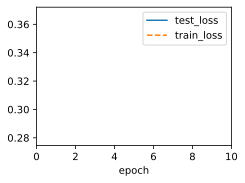

In [5]:
run = 1
lr = 0.01
epochs = 10
split = 0.5
batch_size = 8
shuffle = False

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="iris-neural-regression",
    name=f"experiment_{run}",
    # track hyperparameters and run metadata
    config={
    "architecture": "Linear",
    "dataset": "iris",
    "learning_rate": lr,
    "epochs": epochs,
    "split": split,
    "batch_size": batch_size,
    "shuffle": shuffle
    }
)

# You can get the iris data from https://archive-beta.ics.uci.edu/dataset/53/iris
data = CsvData(3,"data/iris.data", batch_size=batch_size, shuffle=shuffle, split=split)

model = LinearRegression(data.get_feature_count(), 1, lr)

trainer = d2l.Trainer(max_epochs=epochs)
trainer.fit(model, data)

wandb.finish()


Let's do it again, but change some things.

epoch,▁▂▃▄▅▅▆▇█
test_loss,▅▇▃▁▅▅▃█▁
train_loss,██▄▁▃▂▄▇▅
epoch,9
test_loss,0.65393
train_loss,0.9644


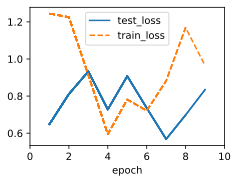

In [6]:
run = 2
lr = 0.01
epochs = 10
split = 0.9
batch_size = 8
shuffle = True

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="iris-neural-regression",
    name=f"experiment_{run}",
    # track hyperparameters and run metadata
    config={
    "architecture": "Linear",
    "dataset": "iris",
    "learning_rate": lr,
    "epochs": epochs,
    "split": split,
    "batch_size": batch_size,
    "shuffle": shuffle
    }
)

# You can get the iris data from https://archive-beta.ics.uci.edu/dataset/53/iris
data = CsvData(3,"data/iris.data", batch_size=batch_size, shuffle=shuffle, split=split)

model = LinearRegression(data.get_feature_count(), 1, lr)

trainer = d2l.Trainer(max_epochs=epochs)
trainer.fit(model, data)

wandb.finish()

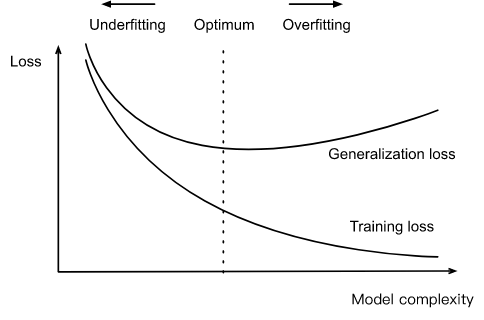